In [2]:
import pandas as pd
import plotly.express as px
from pathlib import Path
import gzip
import os

# --- Funciones para cargar los datos ---

# Obtener la ruta del directorio actual (funciona en scripts y Jupyter Notebooks)
current_dir = os.path.dirname(os.path.abspath("__file__"))


# Construir BASE_DIR a partir de current_dir
BASE_DIR = Path(current_dir).resolve().parent.parent

# --- Resto del código ---

def load_dependency_data(filename="dependencias_consolidadas.csv.gz"):
    csv_path = r"C:\Users\Usuario\Documents\Github\Seguridad económica\src\data\processed\Dependencias consolidadas\dependencias_consolidadas.csv.gz"
    try:
        with gzip.open(csv_path, 'rt', encoding='utf-8') as file:
            return pd.read_csv(file)
    except Exception as e:
        print(f"Error al cargar el archivo de dependencias: {e}")
        return None

def load_clustering_data(filename="agglomerative_clustering_results.csv"):
    clustering_path = r"C:\Users\Usuario\Documents\Github\Seguridad económica\src\data\processed\comunidades\agglomerative_clustering_results.csv"
    try:
        return pd.read_csv(clustering_path, sep=';')
    except Exception as e:
        print(f"Error al cargar el archivo de clustering: {e}")
        return None

# --- Cargar los datos ---
dependency_data = load_dependency_data()
clustering_data = load_clustering_data()

if dependency_data is None or clustering_data is None:
    print("Error al cargar los datos. Verifica las rutas y los archivos.")
else:
    # --- 1. Mapa Coroplético de Dependencias por País (Comparativo DEU vs. ESP) ---

    def create_dependency_map(dependency_data, country):
        filtered_data = dependency_data[dependency_data['dependent_country'] == country]
        country_avg_dependency = filtered_data.groupby('supplier_country')['dependency_value'].mean().reset_index()
        
        merged_data = pd.merge(
            country_avg_dependency,
            clustering_data, 
            left_on='supplier_country',
            right_on='iso_d',
            how='left'
        )
        
        fig = px.choropleth(
            merged_data,
            locations='supplier_country',
            color='dependency_value',
            hover_name='supplier_country',
            color_continuous_scale='RdBu_r',
            title=f'Dependencia Promedio de {country}'
        )
        fig.update_geos(fitbounds="locations", visible=False)
        fig.update_layout(
            geo=dict(
                showframe=False,
                showcoastlines=False,
                projection_type='equirectangular'
            )
        )
        return fig

    fig_deu_map = create_dependency_map(dependency_data, 'DEU')
    fig_deu_map.show()
    fig_esp_map = create_dependency_map(dependency_data, 'ESP')
    fig_esp_map.show()

    # Para mostrar en Streamlit:
    # import streamlit as st
    # st.plotly_chart(fig_deu_map)
    # st.plotly_chart(fig_esp_map)

    # --- 2. Treemap de Dependencias por Industria y País (Comparativo DEU vs. ESP) ---

    def create_dependency_treemap(dependency_data, clustering_data, country):
        filtered_data = dependency_data[dependency_data['dependent_country'] == country]
        
        merged_data = pd.merge(
            filtered_data,
            clustering_data,
            left_on='supplier_country',
            right_on='iso_d',
            how='left'
        )

        fig = px.treemap(
            merged_data,
            path=['industry', 'supplier_country', 'cluster'],
            values='dependency_value',
            color='cluster',
            title=f'Treemap de Dependencias para {country}',
            color_discrete_sequence=px.colors.qualitative.Set1  # Puedes ajustar los colores
        )
        return fig

    fig_deu_treemap = create_dependency_treemap(dependency_data, clustering_data, 'DEU')
    fig_esp_treemap = create_dependency_treemap(dependency_data, clustering_data, 'ESP')

    # Para mostrar en Streamlit:
    # st.plotly_chart(fig_deu_treemap)
    # st.plotly_chart(fig_esp_treemap)

    # --- 3. Gráfico de Barras de Dependencia por Cluster (Comparativo DEU vs. ESP) ---

    def create_dependency_cluster_barplot(dependency_data, clustering_data):
        merged_data = pd.merge(
            dependency_data,
            clustering_data,
            left_on='supplier_country',
            right_on='iso_d',
            how='left'
        )

        cluster_dependency = merged_data.groupby(['dependent_country', 'cluster'])['dependency_value'].sum().reset_index()

        fig = px.bar(
            cluster_dependency,
            x='cluster',
            y='dependency_value',
            color='dependent_country',
            barmode='group',
            title='Dependencia Total por Cluster (DEU vs. ESP)',
            labels={'dependency_value': 'Dependencia Total', 'cluster': 'Cluster', 'dependent_country': 'País'}
        )
        return fig

    fig_cluster_barplot = create_dependency_cluster_barplot(dependency_data, clustering_data)

    # Para mostrar en Streamlit:
    # st.plotly_chart(fig_cluster_barplot)

    # --- 4. Gráfico de Dispersión: Dependencia vs. Variables de Clustering (Comparativo DEU vs. ESP) ---

    def create_dependency_scatterplot(dependency_data, clustering_data, country, variable):
        filtered_data = dependency_data[dependency_data['dependent_country'] == country]
        
        merged_data = pd.merge(
            filtered_data,
            clustering_data,
            left_on='supplier_country',
            right_on='iso_d',
            how='left'
        )
        
        supplier_avg_dependency = merged_data.groupby(['supplier_country', variable])['dependency_value'].mean().reset_index()

        fig = px.scatter(
            supplier_avg_dependency,
            x=variable,
            y='dependency_value',
            title=f'Dependencia vs. {variable} para {country}',
            labels={'dependency_value': 'Dependencia Promedio', variable: variable},
            hover_name='supplier_country'
        )
        return fig
    
    # Crear gráficos para España
    fig_esp_scatter_pca_geo = create_dependency_scatterplot(dependency_data, clustering_data, 'ESP', 'pca_geo_norm')
    fig_esp_scatter_famd_trade = create_dependency_scatterplot(dependency_data, clustering_data, 'ESP', 'famd_trade_norm')
    fig_esp_scatter_famd_cult = create_dependency_scatterplot(dependency_data, clustering_data, 'ESP', 'famd_cult_norm')

    # Crear gráficos para Alemania
    fig_deu_scatter_pca_geo = create_dependency_scatterplot(dependency_data, clustering_data, 'DEU', 'pca_geo_norm')
    fig_deu_scatter_famd_trade = create_dependency_scatterplot(dependency_data, clustering_data, 'DEU', 'famd_trade_norm')
    fig_deu_scatter_famd_cult = create_dependency_scatterplot(dependency_data, clustering_data, 'DEU', 'famd_cult_norm')

    # Para mostrar en Streamlit:
    # st.plotly_chart(fig_esp_scatter_pca_geo)
    # st.plotly_chart(fig_esp_scatter_famd_trade)
    # st.plotly_chart(fig_esp_scatter_famd_cult)
    # st.plotly_chart(fig_deu_scatter_pca_geo)
    # st.plotly_chart(fig_deu_scatter_famd_trade)
    # st.plotly_chart(fig_deu_scatter_famd_cult)

    # --- 5. Top 5 Industrias con Mayor Dependencia (Comparativo DEU vs. ESP) ---

    def create_top_industries_barplot(dependency_data, country):
        filtered_data = dependency_data[dependency_data['dependent_country'] == country]
        top_industries = filtered_data.groupby('industry')['dependency_value'].sum().nlargest(5).reset_index()

        fig = px.bar(
            top_industries,
            x='dependency_value',
            y='industry',
            orientation='h',
            title=f'Top 5 Industrias con Mayor Dependencia para {country}',
            labels={'dependency_value': 'Dependencia Total', 'industry': 'Industria'},
            text='dependency_value'
        )
        fig.update_traces(texttemplate='%{text:.3s}', textposition='outside')
        return fig

    fig_deu_top_industries = create_top_industries_barplot(dependency_data, 'DEU')
    fig_esp_top_industries = create_top_industries_barplot(dependency_data, 'ESP')

    # Para mostrar en Streamlit:
    # st.plotly_chart(fig_deu_top_industries)
    # st.plotly_chart(fig_esp_top_industries)


In [3]:
import pandas as pd
import plotly.express as px
from pathlib import Path
import gzip
import os

# --- Funciones para cargar los datos ---

# Obtener la ruta del directorio actual (funciona en scripts y Jupyter Notebooks)
current_dir = os.path.dirname(os.path.abspath("__file__"))

# Construir BASE_DIR a partir de current_dir
BASE_DIR = Path(current_dir).resolve().parent.parent

def load_dependency_data(filename="dependencias_consolidadas.csv.gz"):
    csv_path = r"C:\Users\Usuario\Documents\Github\Seguridad económica\src\data\processed\Dependencias consolidadas\dependencias_consolidadas.csv.gz"
    try:
        with gzip.open(csv_path, 'rt', encoding='utf-8') as file:
            return pd.read_csv(file)
    except Exception as e:
        print(f"Error al cargar el archivo de dependencias: {e}")
        return None

def load_clustering_data(filename="agglomerative_clustering_results.csv"):
    clustering_path = r"C:\Users\Usuario\Documents\Github\Seguridad económica\src\data\processed\comunidades\agglomerative_clustering_results.csv"
    try:
        return pd.read_csv(clustering_path, sep=';')
    except Exception as e:
        print(f"Error al cargar el archivo de clustering: {e}")
        return None

# --- Cargar los datos ---
dependency_data = load_dependency_data()
clustering_data = load_clustering_data()

if dependency_data is None or clustering_data is None:
    print("Error al cargar los datos. Verifica las rutas y los archivos.")
else:
    # --- Función para crear el treemap ---
    def create_dependency_treemap(dependency_data, clustering_data, country):
        filtered_data = dependency_data[dependency_data['dependent_country'] == country]
        
        merged_data = pd.merge(
            filtered_data,
            clustering_data,
            left_on='supplier_country',
            right_on='iso_d',
            how='left'
        )

        # Manejar valores nulos en la columna 'cluster'
        merged_data['cluster'] = merged_data['cluster'].fillna('Sin Cluster')

        fig = px.treemap(
            merged_data,
            path=['cluster', 'supplier_country'],  # Organización por cluster y luego por país
            values='dependency_value',
            color='cluster',
            title=f'Treemap de Dependencias para {country}',
            color_discrete_sequence=px.colors.qualitative.Set1  # Puedes ajustar los colores
        )
        return fig

    # --- Crear y mostrar el treemap para Alemania y España---
    fig_deu = create_dependency_treemap(dependency_data, clustering_data, 'DEU')
    fig_esp = create_dependency_treemap(dependency_data, clustering_data, 'ESP')

    fig_deu.show()
    fig_esp.show()

In [4]:
import pandas as pd
import numpy as np

def crear_tabla_estrategica(dep_data, cluster_data):
   sectores = {
       'Energía': [
           'Extraction crude petroleum and natural gas',
           'Electricity distribution & control apparatus', 
           'Processing of nuclear fuel',
           'Mining of hard coal'
       ],
       'Tecnología': [
           'Electronic valves tubes etc.',
           'TV/radio transmitters; line comm. apparatus',
           'Office accounting and computing machinery',
           'Other special purpose machinery'
       ],
       'Materias críticas': [
           'Basic precious and non-ferrous metals',   # Incluye litio
           'Basic iron and steel',
           'Basic chemicals except fertilizers',
           'Fertilizers and nitrogen compounds',
           'Accumulators primary cells and batteries', # Baterías
           'Electric motors generators and transformers', # Motores eléctricos
           'Other non-metallic mineral products n.e.c.' # Materiales especiales
       ],
       'Defensa y Salud': [
           'Pharmaceuticals medicinal chemicals etc.',
           'Medical surgical and orthopaedic equipment',
           'Weapons and ammunition',
           'Aircraft and spacecraft',
           'Measuring/testing/navigating appliances etc.'
       ]
   }

   # Crear mapping de países a clusters
   cluster_map = dict(zip(cluster_data['iso_d'], cluster_data['cluster']))
   
   resultados = []
   
   for sector, industrias in sectores.items():
       for industria in industrias:
           # Datos España
           esp = dep_data[
               (dep_data['dependent_country'] == 'ESP') & 
               (dep_data['industry'] == industria)
           ].nlargest(1, 'dependency_value')
           
           # Datos Alemania
           deu = dep_data[
               (dep_data['dependent_country'] == 'DEU') & 
               (dep_data['industry'] == industria)
           ].nlargest(1, 'dependency_value')
           
           resultados.append({
               'Sector': sector,
               'Industria': industria,
               'ESP_valor': esp['dependency_value'].iloc[0] if not esp.empty else np.nan,
               'ESP_pais': esp['supplier_country'].iloc[0] if not esp.empty else '',
               'ESP_cluster': cluster_map.get(esp['supplier_country'].iloc[0], np.nan) if not esp.empty else np.nan,
               'DEU_valor': deu['dependency_value'].iloc[0] if not deu.empty else np.nan,
               'DEU_pais': deu['supplier_country'].iloc[0] if not deu.empty else '',
               'DEU_cluster': cluster_map.get(deu['supplier_country'].iloc[0], np.nan) if not deu.empty else np.nan
           })
   
   return pd.DataFrame(resultados)

# Para dar formato a la tabla con colores:
def estilizar_tabla(df):
   cluster_colors = {
       1: 'background-color: #FF4444',  # Rojo - Desafíos Geopolíticos
       0: 'background-color: #FFA500',  # Naranja - Economías Emergentes
       4: 'background-color: #FFD700',  # Amarillo - América Latina
       2: 'background-color: #90EE90',  # Verde claro - Socios Históricos
       3: 'background-color: #228B22'   # Verde - Economías Avanzadas
   }
   
   def _colorear_clusters(val):
       return cluster_colors.get(val, '')
       
   return df.style.apply(lambda x: [''] * len(x) if x.name != 'ESP_cluster' else [_colorear_clusters(v) for v in x], axis=1)\
                 .apply(lambda x: [''] * len(x) if x.name != 'DEU_cluster' else [_colorear_clusters(v) for v in x], axis=1)

# Uso:
tabla = crear_tabla_estrategica(dependency_data, clustering_data)
tabla_estilizada = estilizar_tabla(tabla)
tabla_estilizada

,Sector,Industria,ESP_valor,ESP_pais,ESP_cluster,DEU_valor,DEU_pais,DEU_cluster
0,Energía,Extraction crude petroleum and natural gas,0.419000,USA,2,0.440000,RUS,1
1,Energía,Electricity distribution & control apparatus,1.000000,AUT,3,1.000000,AUT,3
2,Energía,Processing of nuclear fuel,1.000000,AUS,0,1.000000,AUS,0
3,Energía,Mining of hard coal,1.000000,KAZ,0,1.000000,KAZ,0
4,Tecnología,Electronic valves tubes etc.,0.601000,USA,2,0.870000,USA,2
5,Tecnología,TV/radio transmitters; line comm. apparatus,0.934000,CHN,1,0.967000,CHN,1
6,Tecnología,Office accounting and computing machinery,0.985000,SGP,3,0.985000,SGP,3
7,Tecnología,Other special purpose machinery,0.698000,DEU,3,0.425000,USA,2
8,Materias críticas,Basic precious and non-ferrous metals,0.479000,CHN,1,0.446000,USA,2
9,Materias críticas,Basic iron and steel,0.262000,DEU,3,0.202000,ITA,3


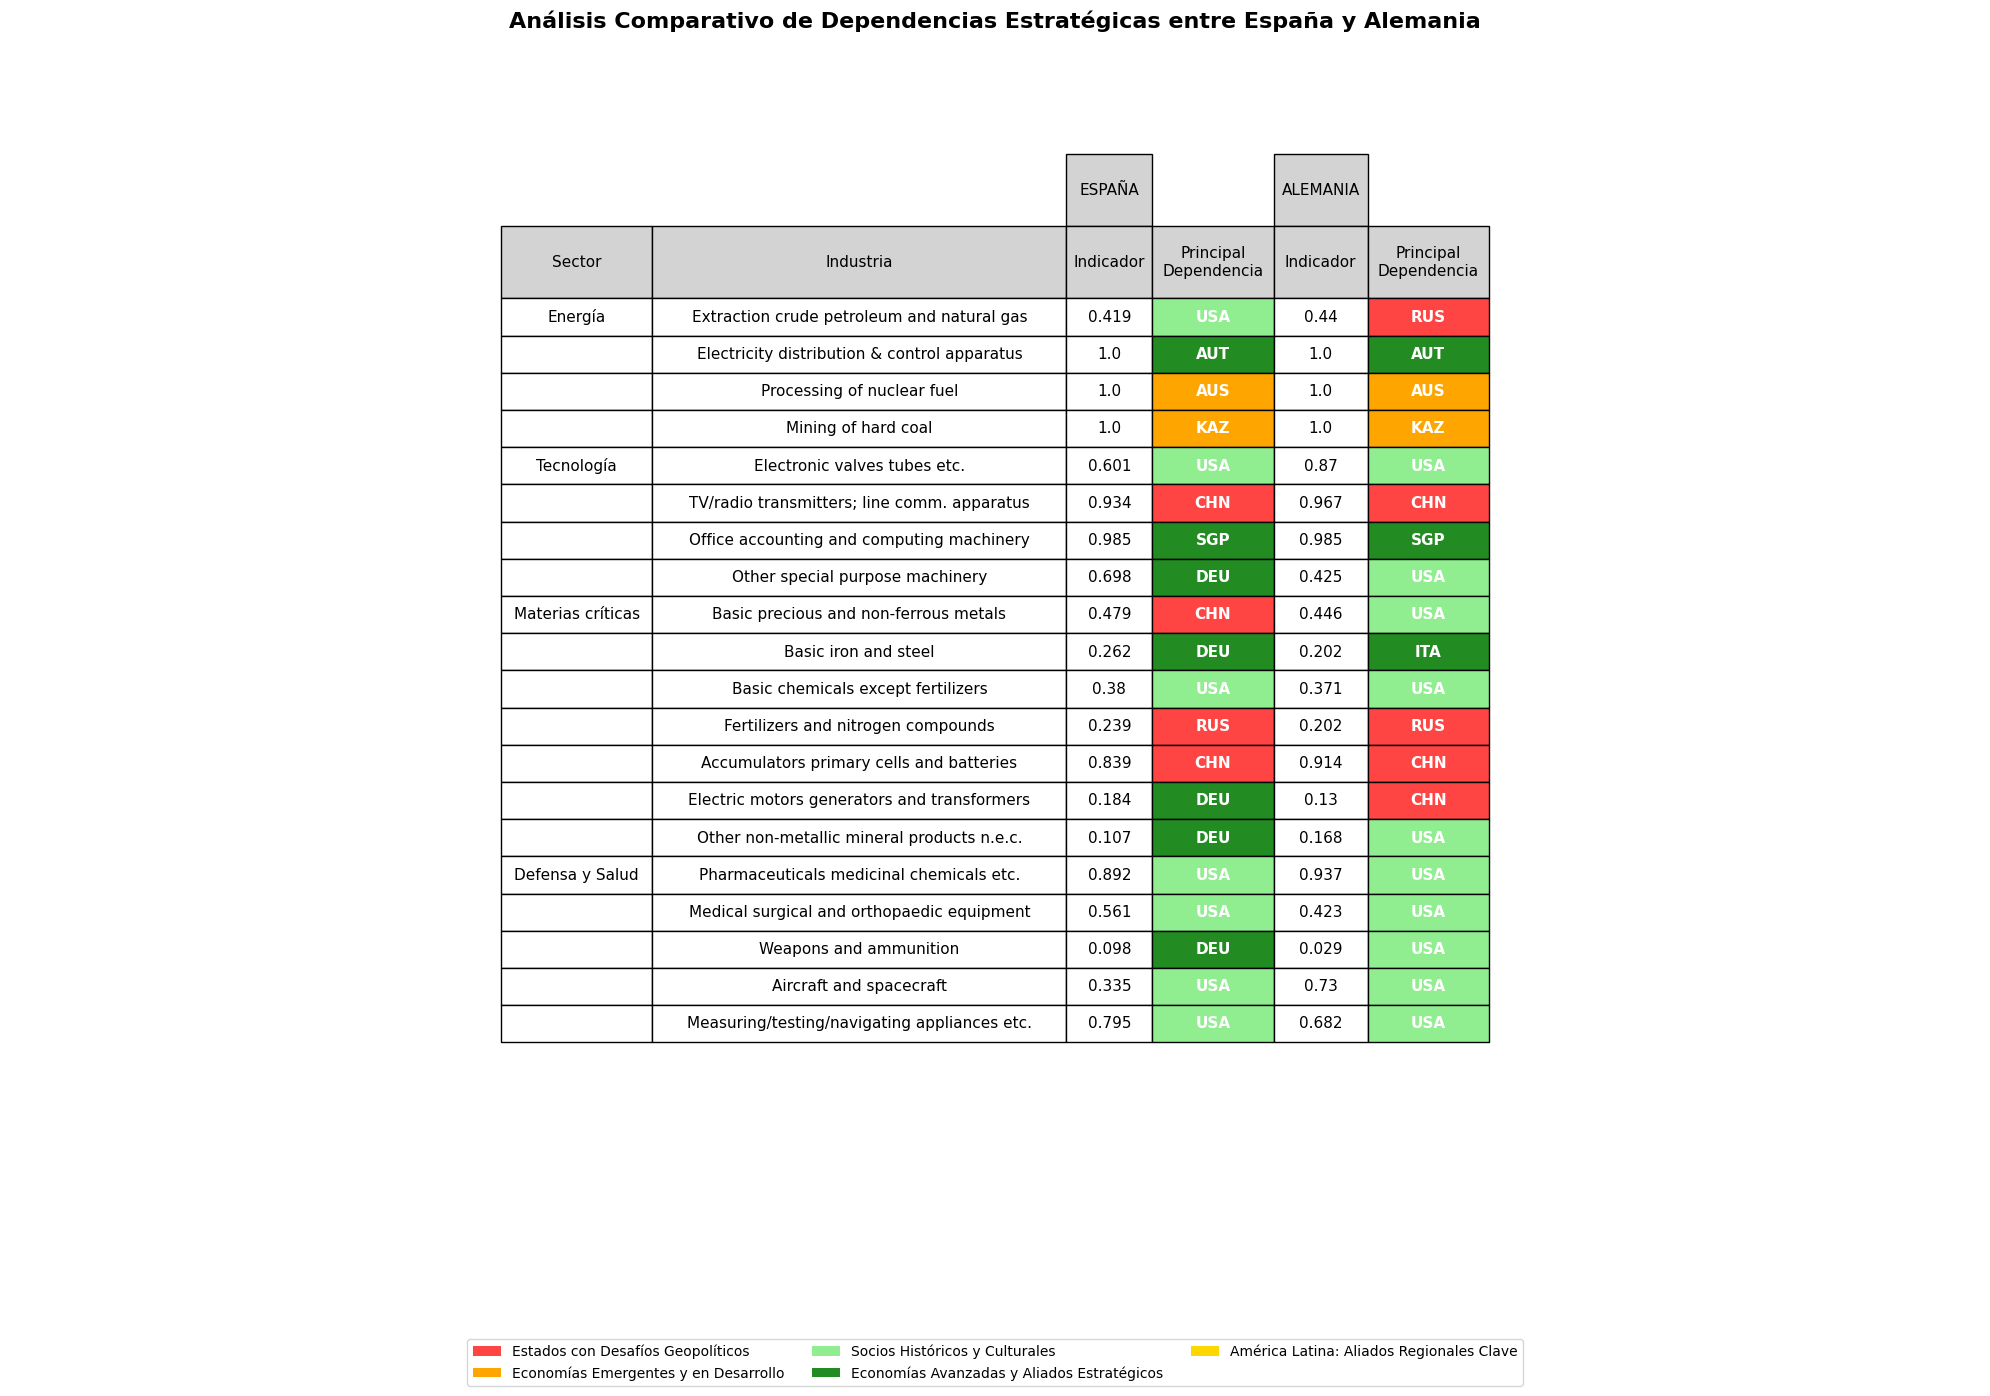

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def crear_tabla_visual(df):
   
   
   cluster_colors = {
       1: '#FF4444',  
       0: '#FFA500',  
       2: '#90EE90',  
       3: '#228B22',  
       4: '#FFD700'   
   }
   
   cluster_nombres = {
       1: 'Estados con Desafíos Geopolíticos',
       0: 'Economías Emergentes y en Desarrollo',
       2: 'Socios Históricos y Culturales',
       3: 'Economías Avanzadas y Aliados Estratégicos',
       4: 'América Latina: Aliados Regionales Clave'
   }
   
   fig, ax = plt.subplots(figsize=(20, 14))
   
   for spine in ax.spines.values():
       spine.set_visible(False)

   # Modificar Sector
   df_mod = df.copy()
   prev_sector = ""
   for idx, row in df_mod.iterrows():
       if row['Sector'] == prev_sector:
           df_mod.at[idx, 'Sector'] = ""
       else:
           prev_sector = row['Sector']

   cell_values = df_mod[['Sector', 'Industria', 'ESP_valor', 'ESP_pais', 'DEU_valor', 'DEU_pais']].values

   # Crear tabla base sin headers
   tabla = ax.table(
       cellText=cell_values,
       loc='center',
       cellLoc='center'
   )
   
   tabla.auto_set_column_width([0,1,2,3,4,5])
   tabla.set_fontsize(11)
   tabla.scale(1.5, 2)
   
   # Headers con fondo gris
   tabla.add_cell(-1, 0, width=1, height=0.06, text='Sector', 
                 loc='center', facecolor='lightgray')
   tabla.add_cell(-1, 1, width=1, height=0.06, text='Industria', 
                 loc='center', facecolor='lightgray')
   
   # España header y subheaders
   tabla.add_cell(-2, 2, width=2, height=0.06, text='ESPAÑA', 
                 loc='center', facecolor='lightgray')
   tabla.add_cell(-1, 2, width=1, height=0.06, text='Indicador', 
                 loc='center', facecolor='lightgray')
   tabla.add_cell(-1, 3, width=1, height=0.06, text='Principal\nDependencia', 
                 loc='center', facecolor='lightgray')
   
   # Alemania header y subheaders  
   tabla.add_cell(-2, 4, width=2, height=0.06, text='ALEMANIA', 
                 loc='center', facecolor='lightgray')
   tabla.add_cell(-1, 4, width=1, height=0.06, text='Indicador', 
                 loc='center', facecolor='lightgray')
   tabla.add_cell(-1, 5, width=1, height=0.06, text='Principal\nDependencia', 
                 loc='center', facecolor='lightgray')
   
   for idx, row in df.iterrows():
       tabla._cells[(idx, 3)].set_facecolor(cluster_colors[row['ESP_cluster']])
       tabla._cells[(idx, 5)].set_facecolor(cluster_colors[row['DEU_cluster']])
       tabla._cells[(idx, 3)].set_text_props(color='white', weight='bold')
       tabla._cells[(idx, 5)].set_text_props(color='white', weight='bold')

   # Leyenda
   legend_elements = [
       mpatches.Patch(facecolor=color, label=cluster_nombres[cluster_id])
       for cluster_id, color in cluster_colors.items()
   ]
   ax.legend(handles=legend_elements, 
            loc='upper center', 
            bbox_to_anchor=(0.5, -0.05),
            ncol=3,
            fontsize=10)

   ax.set_xticks([])
   ax.set_yticks([])
   
   plt.title('Análisis Comparativo de Dependencias Estratégicas entre España y Alemania', 
            pad=30, size=16, weight='bold')
   plt.tight_layout()
   return fig

fig = crear_tabla_visual(tabla)
plt.show()

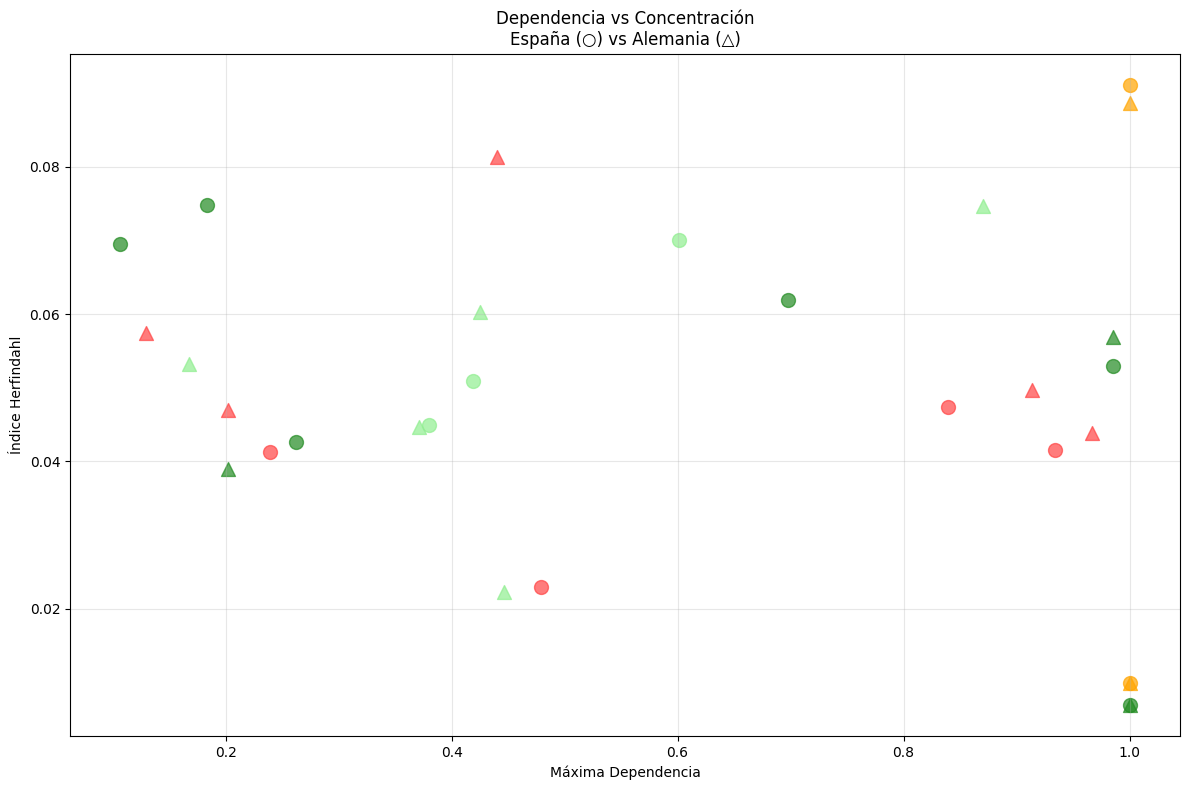

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def crear_scatter_dependencias(df, cluster_data):
   
    
    # Colores por cluster
    cluster_colors = {
        1: '#FF4444',  # Rojo
        0: '#FFA500',  # Naranja
        2: '#90EE90',  # Verde claro
        3: '#228B22',  # Verde
        4: '#FFD700'   # Amarillo
    }
    
    # Crear figura
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Procesar solo las industrias estratégicas
    industrias_estrategicas = [
        'Extraction crude petroleum and natural gas',
        'Electricity distribution & control apparatus',
        'Processing of nuclear fuel',
        'Mining of hard coal',
        'Electronic valves tubes etc.',
        'TV/radio transmitters; line comm. apparatus',
        'Office accounting and computing machinery',
        'Other special purpose machinery',
        'Basic precious and non-ferrous metals',
        'Basic iron and steel',
        'Basic chemicals except fertilizers',
        'Fertilizers and nitrogen compounds',
        'Accumulators primary cells and batteries',
        'Electric motors generators and transformers',
        'Other non-metallic mineral products n.e.c.'
    ]
    
    for industria in industrias_estrategicas:
        # Datos España
        datos_esp = df[
            (df['dependent_country'] == 'ESP') & 
            (df['industry'] == industria)
        ]
        if not datos_esp.empty:
            herf_esp = np.sum(np.square(
                datos_esp['dependency_value'] / datos_esp['dependency_value'].sum()
            ))
            max_dep_esp = datos_esp['dependency_value'].max()
            prov_esp = datos_esp.loc[datos_esp['dependency_value'].idxmax(), 'supplier_country']
            cluster_esp = cluster_data[cluster_data['iso_d'] == prov_esp]['cluster'].iloc[0]
            
            ax.scatter(max_dep_esp, herf_esp, 
                      color=cluster_colors[cluster_esp],
                      marker='o', s=100, alpha=0.7,
                      label=f'ESP - {industria}')
        
        # Datos Alemania
        datos_deu = df[
            (df['dependent_country'] == 'DEU') & 
            (df['industry'] == industria)
        ]
        if not datos_deu.empty:
            herf_deu = np.sum(np.square(
                datos_deu['dependency_value'] / datos_deu['dependency_value'].sum()
            ))
            max_dep_deu = datos_deu['dependency_value'].max()
            prov_deu = datos_deu.loc[datos_deu['dependency_value'].idxmax(), 'supplier_country']
            cluster_deu = cluster_data[cluster_data['iso_d'] == prov_deu]['cluster'].iloc[0]
            
            ax.scatter(max_dep_deu, herf_deu,
                      color=cluster_colors[cluster_deu],
                      marker='^', s=100, alpha=0.7,
                      label=f'DEU - {industria}')
    
    ax.set_xlabel('Máxima Dependencia')
    ax.set_ylabel('Índice Herfindahl')
    ax.set_title('Dependencia vs Concentración\nEspaña (○) vs Alemania (△)')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Usar
fig = crear_scatter_dependencias(dependency_data, clustering_data)
plt.show()